In [7]:
! pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [20]:
import cv2
import matplotlib.pyplot as plt
import pydicom
import os, time
import numpy as np
from heapq import heapify, heappush, heappop
from pathlib import Path


CARPETA_TEST = Path("images_test")
exts_validas = [".png", ".jpg", ".jpeg"]

In [22]:
print((CARPETA_TEST / "rx1.jpeg").exists())

True


Se evaluaran el metodo de Huffman y RLE para la compresión de archivos.

In [12]:
def lectura_imagen_gris(path,image):
    """
    Lee una RX en escala de grises (uint8).
    """
    img = cv2.imread(str(path/image),0)
    if img is None:
        raise ValueError(f"No se pudo leer la imagen: {path/image}")
    return img.astype(np.uint8)

In [23]:
rx1 = lectura_imagen_gris(CARPETA_TEST,'rx1.jpeg')
rx2 = lectura_imagen_gris(CARPETA_TEST,'rx2.jpeg')
rx3 = lectura_imagen_gris(CARPETA_TEST,'rx3.jpeg')

In [28]:
plt.style.use('dark_background')

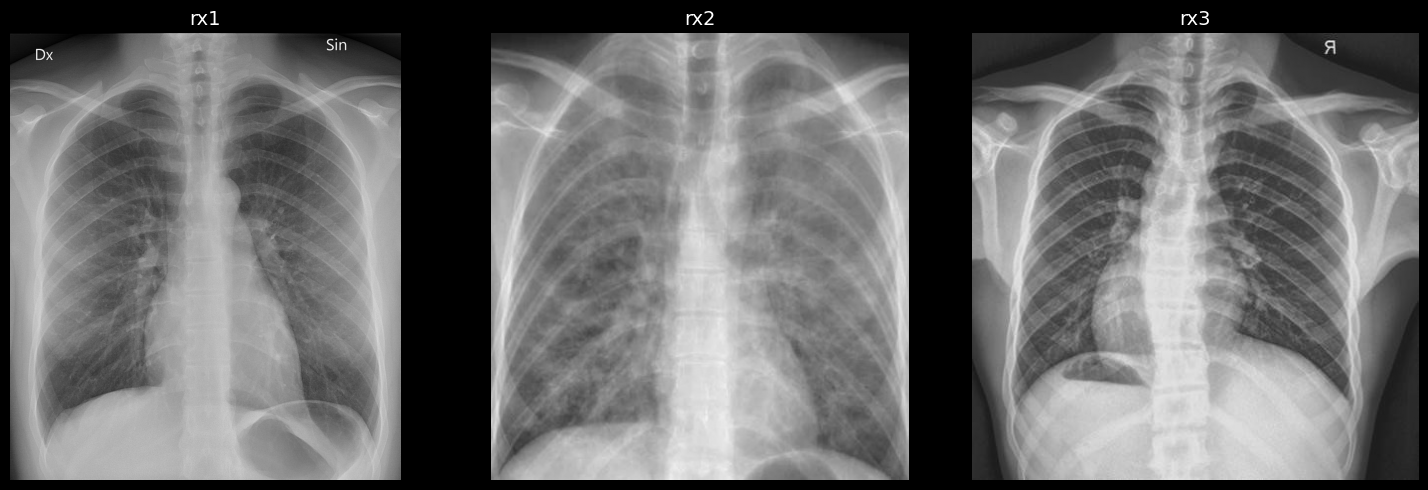

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

imagenes = [rx1, rx2, rx3]
titulos = ["rx1", "rx2", "rx3"]

for ax, img, titulo in zip(axes, imagenes, titulos):
    ax.imshow(img, vmin=0, vmax=255, cmap="gray")
    ax.set_title(titulo, fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.show()


# Histogramas

In [30]:
def histograma(imagen, plot=False, SyP=False):
    x, y = imagen.shape
    hist = np.zeros(256, dtype=int)
    etiqueta = np.zeros(256, dtype=int)
    for i in range(x):
        for j in range(y):
            valor = int(imagen[i, j])
            hist[valor] += 1

    for i in range(256):
        etiqueta[i] = i

    if plot:
        plt.figure(figsize=(16, 4))
        plt.bar(etiqueta, hist, color='yellow')
        plt.xlabel('Intensidad')
        plt.xlim(-10, 260)
        plt.ylabel('Frecuencia')
        plt.title('Histograma')
        if SyP:
            plt.axvspan(-10, 2, color='red', alpha=0.5, label='Sal y pimienta')
        plt.legend()
        plt.show()

    return hist

/var/folders/ny/tjbrv8f94ng1fv509_xbn6sr0000gn/T/ipykernel_26622/1987513805.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


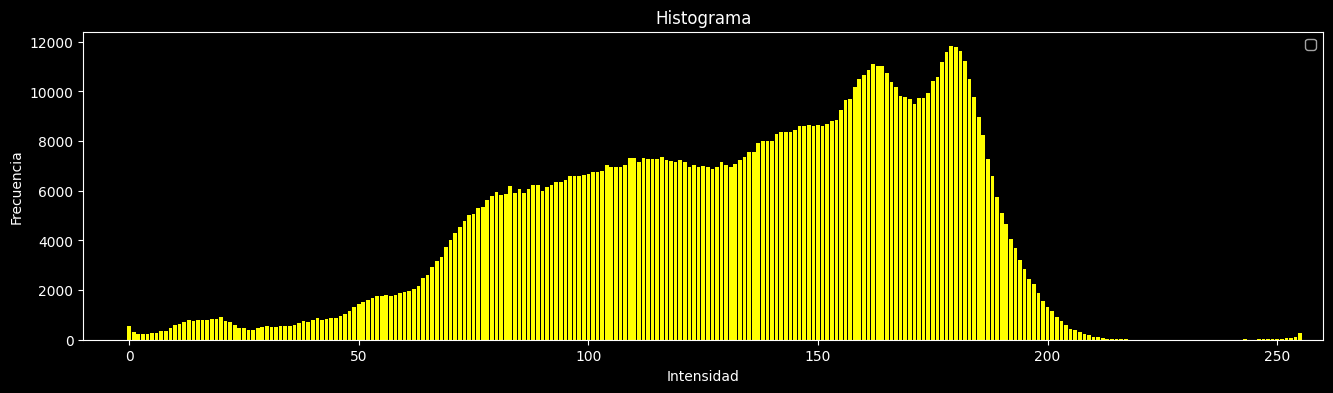

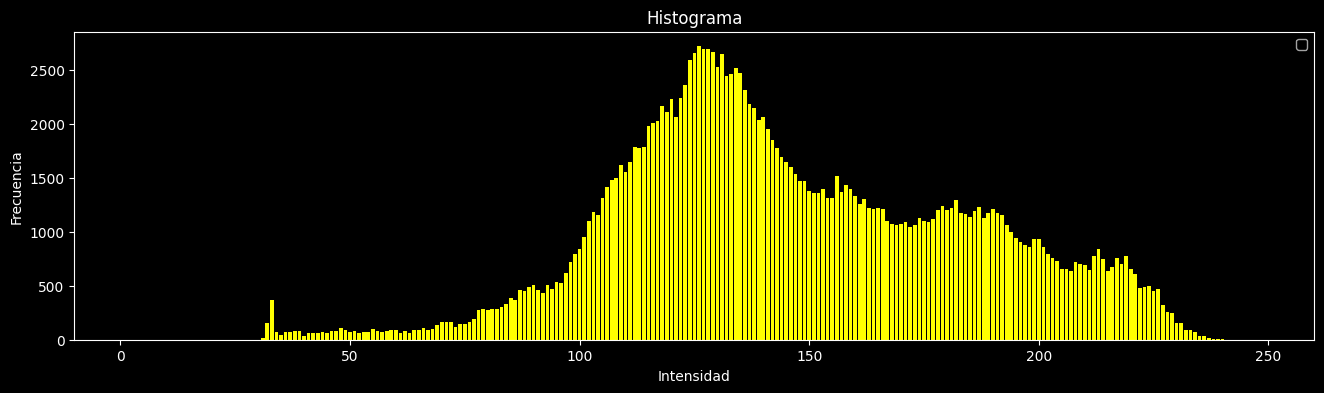

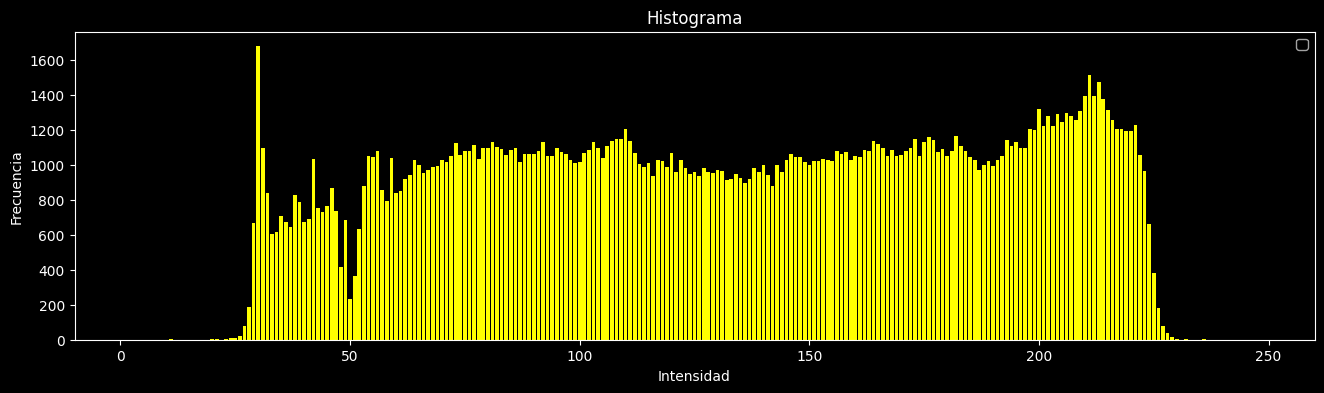

In [31]:
hist=histograma(rx1,True)
hist=histograma(rx2,True)
hist=histograma(rx3,True)

Si bien el histograma no es concluyente, se puede ver baja agrupación en las 3 rx por lo que RLE pareceria no ser adecuado.

# Entropia

In [42]:
def compute_co_occurrence_matrix(image, levels=256):
    img = image.astype(np.int32)  # clave: evitar overflow uint8

    min_gray = int(np.min(img))
    max_gray = int(np.max(img))

    num_levels = max_gray - min_gray + 1
    img_out = np.zeros((num_levels, num_levels), dtype=np.int64)

    h, w = img.shape
    for i in range(h):
        for j in range(w - 1):
            gray1 = int(img[i, j]) - min_gray
            gray2 = int(img[i, j + 1]) - min_gray
            img_out[gray1, gray2] += 1

    img_out = img_out + img_out.T

    s = img_out.sum()
    if s > 0:
        img_out = img_out / s

    return img_out


In [43]:
co  = compute_co_occurrence_matrix(rx1, levels=int(np.max(rx1)) + 1)
ent = entropy(co)
print(f"La entropía de la rx1 es: {ent}")

co2 = compute_co_occurrence_matrix(rx2, levels=int(np.max(rx2)) + 1)
ent2 = entropy(co2)
print(f"La entropía de la rx2 es: {ent2}")

co3 = compute_co_occurrence_matrix(rx3, levels=int(np.max(rx3)) + 1)
ent3 = entropy(co3)
print(f"La entropía de la rx3 es: {ent3}")

La entropía de la rx1 es: 11.507338459623181
La entropía de la rx2 es: 10.89884121071746
La entropía de la rx3 es: 11.68741521244004


No son valores elevados, con lo cual es viable aplicar algúno de los métodos mencionados.

# Prueba por Agrupaciones

In [44]:
def diagonal_order(matrix):
    rows, cols = matrix.shape
    result = []
    for diag in range(rows + cols - 1):
        if diag < cols:
            r = 0
            c = diag
        else:
            r = diag - cols + 1
            c = cols - 1

        while r < rows and c >= 0:
            result.append(matrix[r, c])
            r += 1
            c -= 1
    return np.array(result)

In [45]:
def calcular_agrupaciones_y_promedio(vector, umbral_longitud):
  pixeles = vector.size
  total_longitudes = 0
  num_agrupaciones = 0
  num_agrupaciones_largas = 0

  longitud_actual = 1  # Longitud de la agrupación actual
  for i in range(1, len(vector)):
    if vector[i] == vector[i - 1]:
      longitud_actual += 1
    else:
      total_longitudes += longitud_actual
      num_agrupaciones += 1

      if longitud_actual >= umbral_longitud:
        num_agrupaciones_largas += 1
      longitud_actual = 1


  total_longitudes += longitud_actual
  num_agrupaciones += 1
  if longitud_actual >= umbral_longitud:
    num_agrupaciones_largas += 1

  promedio_longitud = total_longitudes / num_agrupaciones

  porcentaje_agrupaciones_largas = (num_agrupaciones_largas / num_agrupaciones) * 100
  return promedio_longitud, porcentaje_agrupaciones_largas, num_agrupaciones, pixeles

## RX1 --> solo se calculara con una

In [46]:
umbral_longitud = 5
imgPrueba = rx1
vector = imgPrueba.flatten()
vector_vertical = imgPrueba.flatten(order='F')
vector_diagonal = diagonal_order(imgPrueba)



promedio_longitud, porcentaje_largas, num_agrupaciones, total_pixeles = calcular_agrupaciones_y_promedio(vector, umbral_longitud)

# Cálculo para dirección horizontal
print(f"Promedio de longitud de agrupaciones en horizontal: {promedio_longitud}")
print(f"Porcentaje de agrupaciones largas (>={umbral_longitud}): {porcentaje_largas}%")
print(f"Cantidad de agrupaciones en relación al total de píxeles: {num_agrupaciones} de {total_pixeles} ({(num_agrupaciones/total_pixeles)*100:.2f}%)")

Promedio de longitud de agrupaciones en horizontal: 1.12333590522919
Porcentaje de agrupaciones largas (>=5): 0.12649891085183748%
Cantidad de agrupaciones en relación al total de píxeles: 938348 de 1054080 (89.02%)


In [47]:
# Cálculo para dirección vertical
promedio_longitud_v, porcentaje_largas_v, num_agrupaciones_v, total_pixeles = calcular_agrupaciones_y_promedio(vector_vertical, umbral_longitud)
print(f"Dirección Vertical:")
print(f"Promedio de longitud de agrupaciones: {promedio_longitud_v}")
print(f"Porcentaje de agrupaciones largas (>={umbral_longitud}): {porcentaje_largas_v}%")
print(f"Cantidad de agrupaciones en relación al total de píxeles: {num_agrupaciones_v} de {total_pixeles} ({(num_agrupaciones_v/total_pixeles)*100:.2f}%)\n")

Dirección Vertical:
Promedio de longitud de agrupaciones: 1.1179685486496835
Porcentaje de agrupaciones largas (>=5): 0.05896995608011005%
Cantidad de agrupaciones en relación al total de píxeles: 942853 de 1054080 (89.45%)



In [48]:
# Cálculo para dirección diagonal
promedio_longitud_d, porcentaje_largas_d, num_agrupaciones_d, total_pixeles = calcular_agrupaciones_y_promedio(vector_diagonal, umbral_longitud)
print(f"Dirección Diagonal:")
print(f"Promedio de longitud de agrupaciones: {promedio_longitud_d}")
print(f"Porcentaje de agrupaciones largas (>={umbral_longitud}): {porcentaje_largas_d}%")
print(f"Cantidad de agrupaciones en relación al total de píxeles: {num_agrupaciones_d} de {total_pixeles} ({(num_agrupaciones_d/total_pixeles)*100:.2f}%)")

Dirección Diagonal:
Promedio de longitud de agrupaciones: 1.0863813774971218
Porcentaje de agrupaciones largas (>=5): 0.015871919791150272%
Cantidad de agrupaciones en relación al total de píxeles: 970267 de 1054080 (92.05%)


Se puede ver que en todas las direcciones no es viable RLE por tener un % muy bajo de agrupaciones.

# Algoritmos de compresión y resultados

In [49]:
def findCode(tree, val):
  code, padre = tree[val]
  if padre != 'r':
    code = findCode(tree, padre) + code
  return code

## Huffman

In [51]:
def HuffmanEncoding(img):

  # Paso 1: Tamaño de la imagen y rango de niveles de grises
  fil,col = img.shape
  pixeles = fil * col

  # Paso 2: Calculo el histograma normalizado
  hist = histograma(img) / pixeles

  # Paso 3: Genero dos listas vacias para las frecuencias y para la intensidad correspondiente
  lista_histograma = []
  lista_intensidad = []

  # Paso 4: Ingreso valores en las listas
  for i in range(len(hist)):
    if hist[i] != 0:
      lista_histograma.append([hist[i], i])
      lista_intensidad.append(i)

  # Paso 5: Creo mi árbol y el contador para los nodos
  tree = {}
  k = 0 # para ir poniendo nombre a los nodos

  # Paso 6: Hasta que quede sólo un elemento en lista_histograma
  while (len(lista_histograma)>1):
    # 6.1) Ordeno histograma según la frecuencia (hist(i)) de menor a mayor
    lista_histograma.sort(key=lambda x: x[0])

    # 6.2) Selecciono los primeros dos elementos más chicos
    a1 = lista_histograma.pop(0)
    a2 = lista_histograma.pop(0)

    # 6.3) Saco la frecuencia conjunta
    fconj = a1[0]+a2[0]

    # 6.4) Le asigno un nombre (nombre del nodo)
    k += 1
    kstr = str(k)
    nstr = 'n'+kstr

    #6.5) Los vuelvo a agregar a la lista para que se reordenen en el while
    lista_histograma.append([fconj, nstr])

    #6.6) Armo el arbol
    tree[a1[1]] = ['0',nstr]
    tree[a2[1]] = ['1',nstr]

  # Paso 7: Finalizo el árbol
  tree[nstr] = ['','r']

  # Paso 8: Inicio el diccionario con la codificación
  dicc = {}

  # Paso 9: Codifico el árbol
  for a in lista_intensidad:
    code = findCode(tree,a)
    dicc[a] = code

  # Paso 10: Recorro la imagen y genero una lista de string con los valores que le corresponden
  vector = img.flatten()
  comprimida = ''.join([dicc[int(value)] for value in vector])

  size_in_bits = len(comprimida)
  size_in_bytes = size_in_bits / 8

  return comprimida, dicc, img.shape, size_in_bytes

In [52]:
def HuffmanDec(comprimida, dicc, shape):
  # Crear un diccionario inverso para decodificación
  rev_dicc = {v: k for k, v in dicc.items()}
  current_code = ""
  descomprimida = []

  for bit in comprimida:
    current_code += bit
    if current_code in rev_dicc:
      descomprimida.append(rev_dicc[current_code])
      current_code = ""

  # Convertir la lista de valores a una matriz con la forma original
  descomprimida = np.array(descomprimida).reshape(shape)

  return descomprimida

In [54]:
c, d, ish, sib = HuffmanEncoding(rx1)

c2, d2, ish2, sib2 = HuffmanEncoding(rx2)

c3, d3, ish3, sib3 = HuffmanEncoding(rx3)

In [55]:
rx1_HD = HuffmanDec(c, d, ish)
rx2_HD = HuffmanDec(c2, d2, ish2)
rx3_HD = HuffmanDec(c3, d3, ish3)

/var/folders/ny/tjbrv8f94ng1fv509_xbn6sr0000gn/T/ipykernel_26622/637130044.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


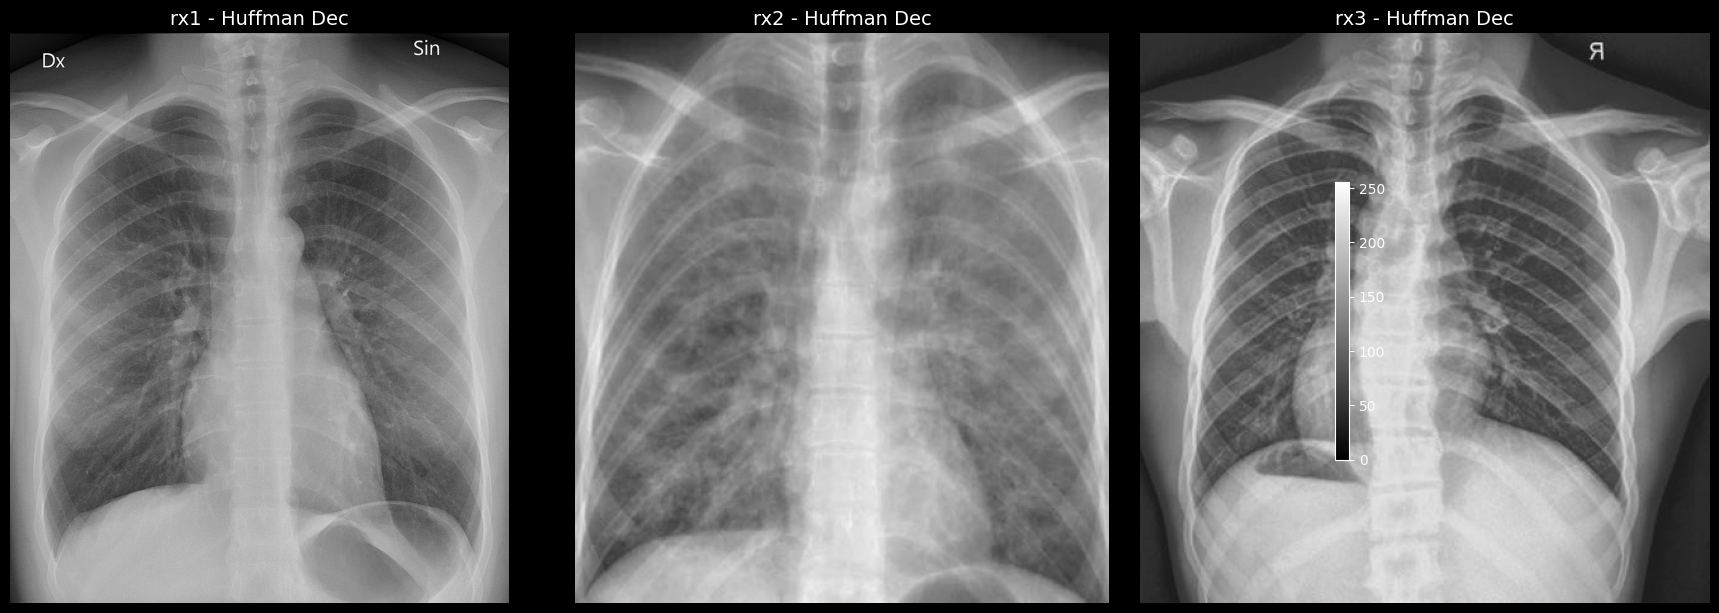

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

imagenes = [rx1_HD, rx2_HD, rx3_HD]
titulos = ["rx1 - Huffman Dec", "rx2 - Huffman Dec", "rx3 - Huffman Dec"]

for ax, img, titulo in zip(axes, imagenes, titulos):
    im = ax.imshow(img, cmap="gray", vmin=0, vmax=255)
    ax.set_title(titulo, fontsize=14)
    ax.axis("off")

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
plt.tight_layout()
plt.show()


In [57]:
print(f"RX1 ocupa {sib} bytes")
print(f"RX2 ocupa {sib2} bytes")
print(f"RX3 ocupa {sib3} bytes")

RX1 ocupa 963416.25 bytes
RX2 ocupa 171764.875 bytes
RX3 ocupa 193935.5 bytes


In [62]:
import time

def benchmark_huffman(img, nombre="imagen"):
    # --- Encoding ---
    start_enc = time.time()
    comprimida, dicc, ish, size_bytes = HuffmanEncoding(img)
    end_enc = time.time()

    # --- Decoding ---
    start_dec = time.time()
    img_dec = HuffmanDec(comprimida, dicc, ish)
    end_dec = time.time()

    tiempo_enc = end_enc - start_enc
    tiempo_dec = end_dec - start_dec

    print(f"--- {nombre} ---")
    print(f"Tiempo de codificación: {tiempo_enc:.6f} s")
    print(f"Tiempo de decodificación: {tiempo_dec:.6f} s")
    print(f"Tamaño comprimido (aprox): {size_bytes:.2f} bytes\n")

    return img_dec, tiempo_enc, tiempo_dec, size_bytes


In [63]:
rx1_HD, t1_enc, t1_dec, s1 = benchmark_huffman(rx1, "RX1")
rx2_HD, t2_enc, t2_dec, s2 = benchmark_huffman(rx2, "RX2")
rx3_HD, t3_enc, t3_dec, s3 = benchmark_huffman(rx3, "RX3")


--- RX1 ---
Tiempo de codificación: 0.201292 s
Tiempo de decodificación: 0.286221 s
Tamaño comprimido (aprox): 963416.25 bytes

--- RX2 ---
Tiempo de codificación: 0.037304 s
Tiempo de decodificación: 0.053356 s
Tamaño comprimido (aprox): 171764.88 bytes

--- RX3 ---
Tiempo de codificación: 0.039262 s
Tiempo de decodificación: 0.058542 s
Tamaño comprimido (aprox): 193935.50 bytes



## RLE

In [64]:
def RunLengthEncoding(img, modo):
    # Paso 1: Elegir el modo de recorrida
    fil, col = img.shape
    dtype = img.dtype

    # Paso 2: Genero la listaRLE
    caracts_listaRLE = [fil, col, modo, dtype]
    listaRLE = []

    # Paso 3: Recorro la imagen según el modo
    if modo == 0:  # Horizontal
        value = img[0, 0]
        cant = 0
        for i in range(fil):
            for j in range(col):
                nivel_de_gris = img[i, j]
                if nivel_de_gris == value:
                    cant += 1
                else:
                    listaRLE.append(value)
                    listaRLE.append(cant)
                    value = nivel_de_gris
                    cant = 1
        # Agregar el último valor
        listaRLE.append(value)
        listaRLE.append(cant)

    elif modo == 1:  # Vertical
        value = img[0, 0]
        cant = 0
        for j in range(col):
            for i in range(fil):
                nivel_de_gris = img[i, j]
                if nivel_de_gris == value:
                    cant += 1
                else:
                    listaRLE.append(value)
                    listaRLE.append(cant)
                    value = nivel_de_gris
                    cant = 1
        # Agregar el último valor
        listaRLE.append(value)
        listaRLE.append(cant)

    elif modo == 2:  # Diagonal
        value = img[0, 0]
        cant = 0

        # Recorre las diagonales
        for diag in range(fil + col - 1):
            if diag < col:
                start_row = 0
                start_col = diag
            else:
                start_row = diag - col + 1
                start_col = col - 1

            i = start_row
            j = start_col
            while i < fil and j >= 0:
                nivel_de_gris = img[i, j]
                if nivel_de_gris == value:
                    cant += 1
                else:
                    listaRLE.append(value)
                    listaRLE.append(cant)
                    value = nivel_de_gris
                    cant = 1
                i += 1
                j -= 1

        # Agregar el último valor
        listaRLE.append(value)
        listaRLE.append(cant)

    else:
        raise ValueError("Modo de compresión por método RLE incorrecto")

    # Calcular el tamaño en bytes
    size_in_bytes = len(listaRLE) * 2  # Cada par (valor, cantidad) ocupa 2 bytes

    # Paso 4: Devolver los parámetros
    return listaRLE, caracts_listaRLE, size_in_bytes

def decodificacion_RLE(codificada, forma):
    decodificada = []
    for i in range(0, len(codificada), 2):  # Iterar de dos en dos
        p = codificada[i]   # Valor
        r = codificada[i + 1]  # Cantidad
        decodificada.extend([p] * r)  # Expandimos la lista

    filas, columnas = forma[0], forma[1]
    imagen_decodificada = np.array(decodificada).reshape((filas, columnas))  # Reconvertimos a la forma original
    return imagen_decodificada


In [65]:
def decodificacion_RLE(codificada, forma):
    decodificada = []
    for i in range(0, len(codificada), 2):  # Iterar de dos en dos
        p = codificada[i]   # Valor
        r = codificada[i + 1]  # Cantidad
        decodificada.extend([p] * r)  # Expandimos la lista

    filas, columnas = forma[0], forma[1]
    imagen_decodificada = np.array(decodificada).reshape((filas, columnas))  # Reconvertimos a la forma original
    return imagen_decodificada

In [66]:
rx1_RLE, caracts, sibRLE = RunLengthEncoding(rx1, 0)
rx1_RLD = decodificacion_RLE(rx1_RLE, caracts[:2])

rx2_RLE, caracts2, sibRLE2 = RunLengthEncoding(rx2, 0)
rx2_RLD = decodificacion_RLE(rx2_RLE, caracts2[:2])

rx3_RLE, caracts3, sibRLE3 = RunLengthEncoding(rx3, 0)
rx3_RLD = decodificacion_RLE(rx3_RLE, caracts3[:2])

/var/folders/ny/tjbrv8f94ng1fv509_xbn6sr0000gn/T/ipykernel_26622/3337936858.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


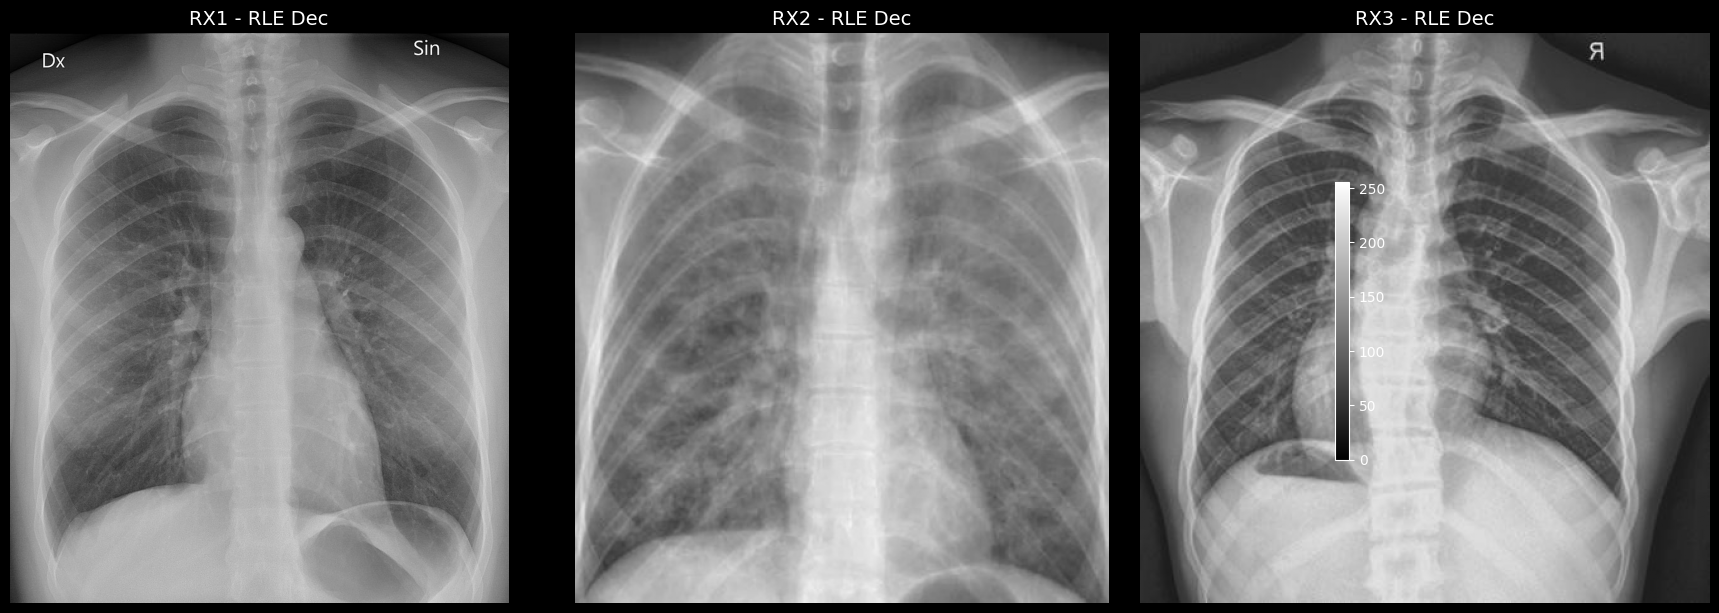

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

imagenes = [rx1_RLD, rx2_RLD, rx3_RLD]
titulos = ["RX1 - RLE Dec", "RX2 - RLE Dec", "RX3 - RLE Dec"]

for ax, img, titulo in zip(axes, imagenes, titulos):
    im = ax.imshow(img, cmap="gray", vmin=0, vmax=255)
    ax.set_title(titulo, fontsize=14)
    ax.axis("off")

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
plt.tight_layout()
plt.show()


In [68]:
print(f"RX1 ocupa {sibRLE} bytes")
print(f"RX2 ocupa {sibRLE2} bytes")
print(f"RX3 ocupa {sibRLE3} bytes")

RX1 ocupa 3753392 bytes
RX2 ocupa 635756 bytes
RX3 ocupa 672184 bytes


In [69]:
def benchmark_rle(img, nombre="imagen"):
    # --- Encoding ---
    start_enc = time.time()
    img_RLE, caracts, sibRLE = RunLengthEncoding(img, 0)
    end_enc = time.time()

    # --- Decoding ---
    start_dec = time.time()
    img_RLD = decodificacion_RLE(img_RLE, caracts[:2])
    end_dec = time.time()

    # --- Tiempos ---
    tiempo_enc = end_enc - start_enc
    tiempo_dec = end_dec - start_dec

    print(f"--- {nombre} (RLE) ---")
    print(f"Tiempo de codificación: {tiempo_enc:.6f} s")
    print(f"Tiempo de decodificación: {tiempo_dec:.6f} s\n")

    return img_RLD, tiempo_enc, tiempo_dec

In [70]:
rx1_RLD, t1_rle_enc, t1_rle_dec = benchmark_rle(rx1, "RX1")
rx2_RLD, t2_rle_enc, t2_rle_dec = benchmark_rle(rx2, "RX2")
rx3_RLD, t3_rle_enc, t3_rle_dec = benchmark_rle(rx3, "RX3")

--- RX1 (RLE) ---
Tiempo de codificación: 0.077847 s
Tiempo de decodificación: 0.076441 s

--- RX2 (RLE) ---
Tiempo de codificación: 0.011785 s
Tiempo de decodificación: 0.012585 s

--- RX3 (RLE) ---
Tiempo de codificación: 0.012867 s
Tiempo de decodificación: 0.013973 s



# Conclusion

En todas las RX los tiempos de codificacion y decodificación son acordes. Sin embargo, el % de agrupación es demasiado bajo para poder utilizar RLE por lo que se concluye que la mejor alternativa es ir por Huffman.

En el trabajo se utilizará como método de compresión al guardar un estudio.